In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# Load datasets
files = [
    'LO_NL_0.18 LPS_P2.csv', 'LO_NL_ND_P2.csv', 'LO_NL_0.47 LPS_P2.csv', 'LO_NL_Transient_P2.csv',
    'LO_GL_0.18 LPS_P2.csv', 'LO_GL_ND_P2.csv', 'LO_GL_0.47 LPS_P2.csv', 'LO_GL_Transient_P2.csv',
    'LO_CC_0.18 LPS_P2.csv', 'LO_CC_ND_P2.csv', 'LO_CC_0.47 LPS_P2.csv', 'LO_CC_Transient_P2.csv',
    'LO_LC_0.18 LPS_P2.csv', 'LO_LC_ND_P2.csv', 'LO_LC_0.47 LPS_P2.csv', 'LO_LC_Transient_P2.csv'
    
]
categories = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2 , 3 ,3 ,3 ,3]



data_list = []
cumulative_offset = 0

for file, cat in zip(files, categories):
    df = pd.read_csv(f'pressure_readings_p2/{file}')
    
    # Ensure the first dataset starts at 0, then shift others accordingly
    if cumulative_offset > 0:
        df['Sample'] = df['Sample'] + cumulative_offset + 1  # +1 prevents overlap
    
    df['Category'] = cat
    data_list.append(df)
    
    # Track the last sample used instead of max()
    cumulative_offset = df['Sample'].max()

# Combine all data
data = pd.concat(data_list).reset_index(drop=True)

print("Min Sample:", data['Sample'].min())
print("Max Sample:", data['Sample'].max())

print("Initial data length:", len(data))
print("Columns after concatenation:", data.columns.tolist())

# Convert 'Sample' to 'Timestamp'
data['Timestamp'] = pd.to_datetime(data['Sample'] * 60, unit='s', origin='2023-01-01')

print("Min Timestamp:", data['Timestamp'].min())
print("Max Timestamp:", data['Timestamp'].max())

data = data.set_index('Timestamp').resample('1S').mean().interpolate().reset_index()
print("After resampling to 1S:", len(data))

data['Category'] = data['Category'].round().astype(int)
print("Unique Category values after rounding:", data['Category'].unique())
# Handle missing values
data = data.dropna()
print("After dropping NaNs in Shell 1:", len(data))

# Normalize 'Value'
scaler = MinMaxScaler()
data['Value'] = scaler.fit_transform(data[['Value']])



Min Sample: 0.0
Max Sample: 593.49503908
Initial data length: 14809489
Columns after concatenation: ['Sample', 'Value', 'Category']
Min Timestamp: 2023-01-01 00:00:00
Max Timestamp: 2023-01-01 09:53:29.702344894


C:\Users\User\AppData\Local\Temp\ipykernel_27008\295827101.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data.set_index('Timestamp').resample('1S').mean().interpolate().reset_index()


After resampling to 1S: 35610
Unique Category values after rounding: [0 1 2 3]
After dropping NaNs in Shell 1: 35610


In [3]:
# Prediction horizon: 2 hours = 7200 seconds (1-second intervals)
horizon_steps = 7200

# Create target: 1 if leak within 2 hours, else 0
data['Target'] = data['Category'].shift(-1).rolling(window=horizon_steps, min_periods=1).max().fillna(0).astype(int)
data.loc[data.index[-horizon_steps:], 'Target'] = 0  # Avoid chained assignment warning

In [4]:
# Set a time-based target: Predict the category of the leak within the next 2 hours
def get_leak_category_within_2_hours(index):
    future_data = data.loc[index:].set_index('Timestamp')
    window = future_data[future_data.index <= data.loc[index, 'Timestamp'] + pd.Timedelta(hours=2)]
    if len(window) > 0:
        return int(window['Category'].max())  # Ensure integer output
    return 0  # Default to no leak if no data

data['Target_Category'] = data.index.map(get_leak_category_within_2_hours)

# Debug: Check unique values in Target_Category
print("Unique Target_Category values:", data['Target_Category'].unique())

# Add rolling features
window = 6
data['Rolling_Mean'] = data['Value'].rolling(window=window).mean().shift(1)
data['Rolling_Std'] = data['Value'].rolling(window=window).std().shift(1)

# Drop NaNs
data = data.dropna()
print("After dropping NaNs in Shell 2:", len(data))

# Define sequence length
seq_length = min(30, max(1, len(data) - 1))
print("Adjusted seq_length:", seq_length)

Unique Target_Category values: [0 1 2 3]
After dropping NaNs in Shell 2: 35604
Adjusted seq_length: 30


In [5]:
# Create sequences
X_list = []
y_list = []
for i in range(len(data) - seq_length):
    seq = data[['Value', 'Rolling_Mean', 'Rolling_Std']].iloc[i:i+seq_length].values
    X_list.append(seq)
    y_list.append(data['Target_Category'].iloc[i+seq_length])

# Convert to NumPy arrays
if len(X_list) > 0:
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
else:
    raise ValueError("No sequences generated. Data length too short.")

# Debug: Check unique values in y before encoding
print("Unique y values before encoding:", np.unique(y))

# One-hot encode the target for multi-class classification
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories=[[0, 1, 2, 3]])
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

print("X shape:", X.shape)
print("y_encoded shape:", y_encoded.shape)

# Train-test split
split = max(1, int(0.8 * len(X)))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_encoded[:split], y_encoded[split:]
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Unique y values before encoding: [0 1 2 3]
X shape: (35574, 30, 3)
y_encoded shape: (35574, 4)
X_train shape: (28459, 30, 3)
X_test shape: (7115, 30, 3)
y_train shape: (28459, 4)
y_test shape: (7115, 4)


Epoch 1/10


c:\Users\User\anaconda3\envs\Research_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


890/890 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3035 - loss: 1.2807 - val_accuracy: 0.9848 - val_loss: 1.1196
Epoch 2/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3140 - loss: 1.2608 - val_accuracy: 0.0347 - val_loss: 1.1653
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3095 - loss: 1.2546 - val_accuracy: 0.0062 - val_loss: 1.1695
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3199 - loss: 1.2577 - val_accuracy: 0.0000e+00 - val_loss: 1.1914
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3144 - loss: 1.2628 - val_accuracy: 0.0118 - val_loss: 1.1321
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3180 - loss: 1.2574 - val_accuracy: 0.0000e+00 - val_loss: 1.1626
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3097 - loss: 1.2535 - val_accuracy: 0.0034 - val_loss: 1.1542
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3197 - loss: 1.2535 - val_accuracy: 0.000

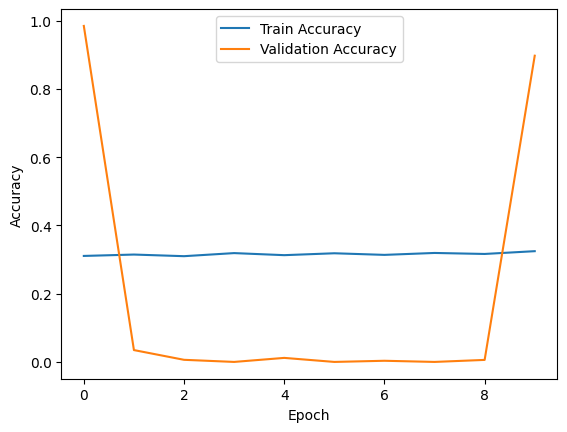

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model for multi-class classification
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))  # 4 outputs: 0 (No Leak), 1 (GL), 2 (CC), 3 (LC)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Predict on test set
y_pred = model.predict(X_test)

# Convert predictions to category probabilities and find the maximum
category_names = ['No Leak', 'Gasket Leak (GL)', 'CC Leak', 'LC Leak']
for i in range(min(5, len(y_pred))):  # Show first 5 predictions as an example
    pred_probs = y_pred[i]
    max_prob_idx = np.argmax(pred_probs)
    max_prob = pred_probs[max_prob_idx] * 100  # Convert to percentage
    predicted_category = category_names[max_prob_idx]
    print(f"Prediction {i+1}:")
    print(f"  Predicted Category: {predicted_category}")
    print(f"  Probability: {max_prob:.2f}%")
    print(f"  All Probabilities: {', '.join([f'{cat}: {prob*100:.2f}%' for cat, prob in zip(category_names, pred_probs)])}")
    print()

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction 1:
  Predicted Category: LC Leak
  Probability: 31.84%
  All Probabilities: No Leak: 5.48%, Gasket Leak (GL): 31.31%, CC Leak: 31.36%, LC Leak: 31.84%

Prediction 2:
  Predicted Category: LC Leak
  Probability: 31.85%
  All Probabilities: No Leak: 5.49%, Gasket Leak (GL): 31.29%, CC Leak: 31.37%, LC Leak: 31.85%

Prediction 3:
  Predicted Category: LC Leak
  Probability: 31.84%
  All Probabilities: No Leak: 5.50%, Gasket Leak (GL): 31.30%, CC Leak: 31.36%, LC Leak: 31.84%

Prediction 4:
  Predicted Category: LC Leak
  Probability: 31.83%
  All Probabilities: No Leak: 5.50%, Gasket Leak (GL): 31.31%, CC Leak: 31.35%, LC Leak: 31.83%

Prediction 5:
  Predicted Category: LC Leak
  Probability: 31.82%
  All Probabilities: No Leak: 5.50%, Gasket Leak (GL): 31.33%, CC Leak: 31.34%, LC Leak: 31.82%

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - loss: 1.1479
Test Loss: 1.1473
Test Accuracy: 0.8975


In [12]:
model.save('Pressure_Predicting.h5')
print("Entire model saved in SavedModel format to 'leak_detection_model' directory")

Entire model saved in SavedModel format to 'leak_detection_model' directory


In [11]:
import joblib
joblib.dump(scaler, 'Predicting_scaller.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'
